<a id = "top"></a>

# Concert Tour Routing Plan Optimization
<font color = red>Implementing Lazy Constraints on MIP Models.</font>

***

#### $\bf{Problem\ description:}$ ${Case\ Study}$

&emsp;&emsp;A popular band is planning a tour across several cities, performing at different venues in each city. The band has a single plane to complete the tour across Canada and a single pilot to carry the band, staff, and the material used to set up the concert. The band has an unique objective for this tour: to deliver a different performance at each city. This requires the plane to carry all the material and instruments for each concert. Their current band manager is responsible for defining the order of the venues given the time windows at which the staff at the venue is available to set up the concert. During their last tour across the U.S., the band had multiple timing problems. Due to manual planning, all concerts in their last tour experienced delays, resulting in additional costs to hire extra staff at each venue. <u>The band wants to optimize their concert route for their tour across Canada to <b>minimize complete travel time and cost while ensuring that the staff time window is respected</b></u>.<br><br>

&emsp;&emsp;The band wants to determine the most efficient route structure for their pilot to reach each venue within the staff time window while ensuring that the tour starts and ends at the band hangar. The objective is to minimize the total distance traveled by the plane while ensuring that each venue location is visited once and that the plane capacity and staff time windows are respected.<br><br>

&emsp;&emsp;The band is asking our consulting firm to develop/create a proof of concept for an optimization software that can meet their requirements. The software will be used by the band manager to plan the
tour across Canada.<br><br>

#### $\bf{Data:}$ 
&emsp;&emsp;The band has a range of potential venues that they need to serve in the tour. The band also knows the time window at each venue, as well as the maximum capacity of the plane and the amount of material (demand) required at each venue.<br>

|    **Description**   | **Value** |
|:--------------------:|:---------:|
| Min number of venues |     80    |
| Max number of venues |    120    |
|   Demand per venue   |   1-4 Kg  |
|    Plane Capacity    |   500 Kg  |


#### $\bf{Note:}$ 
&emsp;&emsp;For this problem, the following assumptions are made:
- The travel time between locations is defined by the Euclidean distance between each location.
- The distance matrix is symmetrical, meaning that the distance between location $i$ and location $j$ is the same as the distance between location $j$ and location $i$.

<br>

### [$\bf{Click\ Here\ to\ Jump\ to\ the\ Implementation\ on\ Canadian\ Cities}$](#ca_implementation)
### [$\bf{Click\ Here\ to\ Jump\ to\ the\ Implementation\ on\ Synthetic\ Data}$](#synthetic_data)
### [$\bf{Click\ Here\ to\ Jump\ to\ the\ Implementation\ on\ Synthetic\ Data\ Considering\ Venue\ Availability}$](#synthetic_data_time)
<br><br>

<br>

***
<a id="ca_implementation"></a>
# $\bf{Implementation:}\ Canadian\ Cities$
In this attempt, we will optimize the routing plan <font color=red>to visit **ALL** top 150 Canadian cities</font> based on their population.
<div align = "right"><a href = '#top'>Back to Top</a></div>

## Import libraries and dataset
1. Import or install libraries and packages to use.
2. Read the Canadian Cities dataset.
3. A function **frame** is created to print the names.

In [1]:
import pandas as pd
import numpy as np

import gurobipy as gp
from gurobipy import *

import math
from itertools import combinations, permutations

import folium
import pprint
import matplotlib.pyplot as plt


# the frame() function is used to print a string with a frame.
def frame(title):
    print("\n"+"-"*(len(title)+4)+"\n| "+title+" |\n"+"-"*(len(title)+4))
    
# Define pretty print
pp = pprint.PrettyPrinter(indent = 1, compact = True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
filePath = "Datasets/"

# Read the file
ca_cities = pd.read_csv(filePath + "canadacities.csv")

# Transform city ranking to demand level
def ranking2demand(x):
    if x == 1:
        return 4
    elif x == 2:
        return 3
    elif x == 3:
        return 2
    elif x == 4:
        return 1
    else:
        "Error"
        
ca_cities["demand"] = ca_cities["ranking"].apply(lambda x: ranking2demand(x))

# Avoid cities with same names (Montreal -> Quebec_Montreal)
ca_cities["city"] = ca_cities[["province_name","city"]].agg("_".join, axis=1)

# Focus on top 150 cities by population
ca_cities = ca_cities.sort_values(by = "population", ascending = False)
ca_cities = ca_cities.head(150)

# Select columns of interest
ca_cities["city"] = ca_cities["city_ascii"]
ca_cities = ca_cities[["id","city","province_name","lat","lng","demand"]].set_index("city")

# Print the data
frame("canadacities.csv")
print("\nNumber of cities:", ca_cities.shape[0])
display(ca_cities.head())


--------------------
| canadacities.csv |
--------------------

Number of cities: 150


,id,province_name,lat,lng,demand
city,,,,,
Toronto,1124279679,Ontario,43.7417,-79.3733,4
Montreal,1124586170,Quebec,45.5089,-73.5617,4
Vancouver,1124825478,British Columbia,49.2500,-123.1000,4
Calgary,1124690423,Alberta,51.0500,-114.0667,4
Edmonton,1124290735,Alberta,53.5344,-113.4903,4


<br>

## Sets and Parameters

$i, j \in Cities $: indices and set of Canada top 150 cities cities based on population.

$\text{Pairings}= \{(i,j) \in Cities \times Cities \}$: Set of allowed pairings

$S \subset Cities$: A subset of the set of Canada top 150 citiesbased on population.

$G = (Cities, Pairings)$: A graph where the set $Cities$ defines the set of nodes and the set $Pairings$ defines the set of edges.

<br>

## Derive Distance Parameters
1 degree of longitude and latitude is approximately 111 kilometer.<br>
Here we use coordinates degree as our distance unit to avoid overcomplicating the formulation.

In [3]:
# Compute pairwise distance matrix
def distance(city1, city2):
    diff_lat = ca_cities.loc[city1]["lat"] - ca_cities.loc[city2]["lat"]
    diff_lng = ca_cities.loc[city1]["lng"] - ca_cities.loc[city2]["lng"]
    return math.sqrt(diff_lat**2 + diff_lng**2)

dist = {(c1, c2): distance(c1, c2) for c1, c2 in combinations(list(ca_cities.index), 2)}

<br>

## Modeling

As mentioned above in the original TSP example, our case is also a symmetric traveling salesman problem, we can make it more efficient by setting the object x[j,i] to x[i,j], instead of a constraint.

In [4]:
m = gp.Model("Concert Tour Routing Plan Optimization")

# Variables: is city 'i' adjacent to city 'j' on the tour?
vars = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')

# Symmetric direction: Copy the object
for i, j in vars.keys():
    vars[j, i] = vars[i, j]  # edge in opposite direction

# Constraints: two edges incident to each city
cons = m.addConstrs(vars.sum(c, '*') == 2 for c in ca_cities.index)

Using license file /Users/ylfaliang/gurobi.lic
Academic license - for non-commercial use only - expires 2024-04-08


<br>

## Callback Definition

Subtour constraints prevent multiple loops in a TSP tour. Because there are an exponential number of these constraints, we don't want to add them all to the model. Instead, we use a callback function to find violated subtour constraints and add them to the model as lazy constraints.

In [5]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys()
                             if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        if len(tour) < len(ca_cities.index):
            # add subtour elimination constr. for every pair of cities in subtour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Given a tuplelist of edges, find the shortest subtour
def subtour(edges):
    unvisited = list(ca_cities.index)[:]
    cycle = list(ca_cities.index)[:] # Dummy - guaranteed to be replaced
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
    return cycle

<br>

## Tune <a href="https://www.gurobi.com/documentation/10.0/refman/parameters.html" style="color:red">Gurobi Parameters</a> : MIP Cuts

These parameters affect the generation of MIP cutting planes. In all cases, a value of -1 corresponds to an automatic setting, which allows the solver to determine the appropriate level of aggressiveness in the cut generation. Unless otherwise noted, settings of 0, 1, and 2 correspond to no cut generation, conservative cut generation, or aggressive cut generation, respectively. The Cuts parameter provides global cut control, affecting the generation of all cuts. This parameter also has a setting of 3, which corresponds to very aggressive cut generation. The other parameters override the global Cuts parameter (so setting Cuts to 2 and CliqueCuts to 0 would generate all cut types aggressively, except clique cuts which would not be generated at all). 

In [6]:
#######################
## IMPORTANT NOTE
#######################

#REMEMBER TO RUN THE FOLLOWING COMMAND BEFORE TESTING OTHER PARAMETERS
#OTHERWISE GUROBI WILL USE ALL THE PREVIOUS PARAMETERS TO SOLVE THE
#MODEL

# Reset the values of the parameters
m.resetParams() # DO NOT COMMENT

#######################

# Run either Method A or Method B.

# A. Tune the model based on the selected parameters (see the parameter list).
m.setParam('FlowCoverCuts', 2)
#m.setParam('GomoryPasses', 2)
#m.setParam('RelaxLiftCuts', 2)

# WARNING: DO NOT USE AUTOMATIC TUNING WITH THE CHOSEN PARAMETERS
# B. Tune the complete formulation (automatic tunning)
#m.tune()

# Write the auto tuning results
#for i in range(m.tuneResultCount):
#    m.getTuneResult(i)
#    m.write('tune result_'+str(i)+'.prm')

Reset all parameters
Changed value of parameter FlowCoverCuts to 2
   Prev: -1  Min: -1  Max: 2  Default: -1


<br>

## Solve the Model

In [7]:
m._vars = vars
m.Params.lazyConstraints = 1
m.optimize(subtourelim)

Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 150 rows, 11175 columns and 22350 nonzeros
Model fingerprint: 0xc2185390
Variable types: 0 continuous, 11175 integer (11175 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 7e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.02s
Presolved: 150 rows, 11175 columns, 22350 nonzeros
Variable types: 0 continuous, 11175 integer (11175 binary)

Root relaxation: objective 1.403792e+02, 230 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  140.37920    0   28          -  140.37920      -     -    0s
     0     0  140.93625    0   22      

<br>

## Analysis

We retrieve the optimal solution of the TSP and verify that the optimal route (or tour) goes to all the cities and returns to the origin city.

In [8]:
# Retrieve solution
vals = m.getAttr('x', vars)
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)

tour = subtour(selected)
assert len(tour) == len(ca_cities)

In [9]:
province_color = {}
color_list = ["rgba(158, 1, 66, 1)",
              "rgba(213, 62, 79, 1)",
              "rgba(244, 109, 67, 1)",
              "rgba(253, 174, 97, 1)",
              "rgba(254, 224, 139, 1)",
              "rgba(230, 245, 152, 1)",
              "rgba(171, 221, 164, 1)",
              "rgba(102, 194, 165, 1)",
              "rgba(50, 136, 189, 1)",
              "rgba(94, 79, 162, 1)"]

for enum, p in enumerate(ca_cities.province_name.unique()):
    province_color[p] = color_list[enum]

In [10]:
# Map the solution
loc_center = [ca_cities.lat.mean(), ca_cities.lng.mean()]

ca_map = folium.Map(location = loc_center, tiles = "cartodbdark_matter" ,zoom_start = 4, control_scale = True)

points = []
for city in tour:
    city_lat = ca_cities.loc[city]["lat"]
    city_lng = ca_cities.loc[city]["lng"]
    province = ca_cities.loc[city]["province_name"]
    points.append((city_lat, city_lng))
    folium.CircleMarker([city_lat, city_lng], radius = int(ca_cities.loc[city]["demand"])**2.5, weight = 0, 
                        fill = True, fill_color = province_color[province], color = province_color[province],
                        tooltip="City: <b>"+city+"<b>").add_to(ca_map)
points.append(points[0])

folium.PolyLine(points, color = "silver").add_to(ca_map)
folium.TileLayer("cartodbpositron").add_to(ca_map)
folium.TileLayer("cartodbdark_matter").add_to(ca_map)
folium.LayerControl().add_to(ca_map)

ca_map

<br>

***
<a id="provided_data"></a>
# $\bf{Implementation:}\ Synthetic\ Data$<br>
In this implementation, we will have the provided data as out venue candidates. We **DON'T** have to visit all venues.
<div align = "right"><a href = '#top'>Back to Top</a></div>

## Read Provided Dataset and Set Scenarios

1. Read the provided dataset.
2. Set the scenarios. The size of the scenario depends on the number of customers being considered.

In [12]:
np.random.seed(53)
plane_capacity = 500

data = pd.read_csv(filePath+"TSPTW_150.txt", delim_whitespace = True, header = 0)

data["DEMAND"] = np.random.randint(1, 5, len(data))

data = data.rename(columns = {"CUST_NO": "venue",
                              "XCOORD":"x",
                              "YCOORD":"y",
                              "DEMAND":"demand",
                              "READY_TIME":"available_from",
                              "DUE_DATE":"available_until"}).set_index("venue").drop("SERVICE_TIME", axis = 1)

scenarios = {"small":80,
             "medium":100,
             "large":120}

# Choose scenarios
data = data.head(scenarios["large"])
display(data)

,x,y,demand,available_from,available_until
venue,,,,,
1,36.0,7.0,2,0.0,959.0
2,46.0,7.0,2,491.0,520.0
3,29.0,27.0,2,181.0,194.0
4,12.0,45.0,2,806.0,840.0
5,44.0,24.0,4,46.0,69.0
6,38.0,36.0,2,152.0,184.0
7,23.0,7.0,3,449.0,460.0
8,40.0,36.0,1,72.0,99.0
9,6.0,2.0,4,409.0,431.0


<br>

## Sets and Parameters

$i, j \in Venues $: indices and set of venues in the provided dataset.

$\text{Pairings}= \{(i,j) \in Venues \times Venues \}$: Set of allowed pairings

$S \subset Venues$: A subset of the set of venues.

$G = (Venues, Pairings)$: A graph where the set $Venues$ defines the set of nodes and the set $Pairings$ defines the set of edges.

<br>

## Derive Distance Parameters
1 degree of longitude and latitude is approximately 111 kilometer.<br>
Here we use coordinates degree as our distance unit to avoid overcomplicating the formulation.

In [13]:
def distance(venue1, venue2):
    diff_lat = data.loc[venue1]["x"] - data.loc[venue2]["x"]
    diff_lng = data.loc[venue1]["y"] - data.loc[venue2]["y"]
    return math.sqrt(diff_lat**2 + diff_lng**2)

dist = {(s1, s2): distance(s1, s2) for s1, s2 in combinations(list(data.index), 2)}

<br>

## Modeling

As mentioned above in the original TSP example, our case is also a symmetric traveling salesman problem, we can make it more efficient by setting the object x[j,i] to x[i,j], instead of a constraint.

In [14]:
m = gp.Model("Concert Tour Routing Plan Optimization: Synthetic Data")

# Variables: is city 'i' adjacent to city 'j' on the tour?
var_edges = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='e')
var_nodes = m.addVars(data.index, vtype=GRB.BINARY, name='n')

# Symmetric direction: Copy the object
#for i, j in var_edges.keys():
#    var_edges[j, i] = var_edges[i, j]  # edge in opposite direction

# Constraints: two edges incident to each city
con_2edges = m.addConstrs(var_edges.sum(v, '*') + var_edges.sum('*', v) == 2*var_nodes[v] for v in data.index)
            
# Constraint: Min number of venues
con_min_venue = m.addConstr(var_nodes.sum('*') >= 80)
# Constraint: Max number of venues
con_max_venue = m.addConstr(var_nodes.sum('*') <= 120)
# Constraint: Plane Capacity
con_capacity = m.addConstr(sum(var_nodes[v]*data.loc[v]["demand"] for v in data.index) <= plane_capacity)


<br>

## Callback Definition

The `subtourelim()` and `subtour()` functions in this implementation are different from the previous ones. In this case, we don't have to visit all venues as we have more than enough venues on our list.

In `subtourelim()`, we set `model._vars` to `var_edges` only since we're checking whether there is any subtours based on the edge variables not the node variables.

In `subtour()`, the unvisited list includes only the venues we decide to visit instead the venues in the whole dataset.

In [15]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # make a list of edges selected in the solution
        model._vars = var_edges
        vals = model.cbGetSolution(model._vars)
        selected = gp.tuplelist((i, j) for i, j in model._vars.keys()
                             if vals[i, j] > 0.5)
        # find the shortest cycle in the selected edge list
        tour = subtour(selected)
        tour.sort()
        if len(tour) < len(selected):
            # add subtour elimination constr. for every pair of cities in subtour
            model.cbLazy(gp.quicksum(model._vars[i, j] for i, j in combinations(tour, 2))
                         <= len(tour)-1)

# Given a tuplelist of edges, find the shortest subtour
def subtour(edges):
    
    chosen = []
    for i, j in edges.select('*', '*'):
        if i not in chosen:
            chosen.append(i)
        if j not in chosen:
            chosen.append(j)
    
    unvisited = chosen[:]
    cycle = chosen[:] # Dummy - guaranteed to be replaced
    
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            
            neighbors = []
            for c, n in edges.select(current, '*'):
                if n in unvisited:
                    neighbors.append(n)
            for n, c in edges.select('*', current):
                if n in unvisited:
                    neighbors.append(n)
                    
        if len(thiscycle) <= len(cycle):
            cycle = thiscycle # New shortest subtour
            
    return cycle

<br>

## Solve the Model

In [16]:
m.resetParams()

m._vars = var_edges
m.Params.lazyConstraints = 1

m.optimize(subtourelim)

if m.getAttr("Status") == GRB.OPTIMAL:
    frame("Optimal Solution Found!")

Reset all parameters
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 123 rows, 7260 columns and 14760 nonzeros
Model fingerprint: 0xf14087f6
Variable types: 0 continuous, 7260 integer (7260 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+01, 5e+02]
Presolve removed 2 rows and 0 columns
Presolve time: 0.02s
Presolved: 121 rows, 7260 columns, 14520 nonzeros
Variable types: 0 continuous, 7260 integer (7260 binary)

Root relaxation: objective 1.827423e+02, 163 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  182.74229    0   38          -  182.74229      

<br>

## Analysis

We retrieve the optimal solution of the TSP and verify <font color=red>whether the number of venues we select fits the requirements</font> (max and min number to visit).<br><br>

- **Tour Plan**

In [17]:
# Retrieve solution
vals = m.getAttr('x', var_edges)
# Show selected edges
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
tour = subtour(selected)

assert len(tour) <= 120
assert len(tour) >= 80

print("Tour Plan ("+str(len(tour))+" venues):")
sequence = ""
for i, v in enumerate(tour):
    if i != len(tour)-1:
        sequence = sequence + str(v) + " -> "
    else:
        sequence = sequence + str(v)
print(sequence)

Tour Plan (80 venues):
4 -> 18 -> 61 -> 31 -> 26 -> 113 -> 97 -> 44 -> 59 -> 40 -> 77 -> 39 -> 82 -> 27 -> 78 -> 85 -> 70 -> 112 -> 99 -> 79 -> 13 -> 34 -> 25 -> 38 -> 33 -> 21 -> 46 -> 37 -> 91 -> 69 -> 100 -> 92 -> 17 -> 36 -> 55 -> 64 -> 57 -> 83 -> 89 -> 67 -> 71 -> 20 -> 41 -> 14 -> 86 -> 15 -> 47 -> 50 -> 110 -> 51 -> 58 -> 16 -> 62 -> 88 -> 49 -> 28 -> 6 -> 8 -> 116 -> 84 -> 101 -> 66 -> 19 -> 48 -> 106 -> 24 -> 30 -> 29 -> 75 -> 11 -> 90 -> 94 -> 93 -> 95 -> 52 -> 108 -> 111 -> 76 -> 98 -> 87


<br>

- **Venues to visit**

In [18]:
node_num = 0
edge_num = 0

nodes = []
edges = []

for v in m.getVars():
    if(v.x >= 0.5):
        if v.varname.startswith("e"):
            edge_num += 1
            edges.append(v.varname)
        if v.varname.startswith("n"):
            node_num += 1
            nodes.append(v.varname)

assert edge_num == node_num

print("Number of selected edges:", edge_num, 
      "\nNumber of selected nodes:", node_num)

print("\nSelected Nodes (venues):")
pp.pprint(nodes)
print("\nSelected Edges (routes):")
pp.pprint(edges)

Number of selected edges: 80 
Number of selected nodes: 80

Selected Nodes (venues):
['n[4]', 'n[6]', 'n[8]', 'n[11]', 'n[13]', 'n[14]', 'n[15]', 'n[16]', 'n[17]',
 'n[18]', 'n[19]', 'n[20]', 'n[21]', 'n[24]', 'n[25]', 'n[26]', 'n[27]',
 'n[28]', 'n[29]', 'n[30]', 'n[31]', 'n[33]', 'n[34]', 'n[36]', 'n[37]',
 'n[38]', 'n[39]', 'n[40]', 'n[41]', 'n[44]', 'n[46]', 'n[47]', 'n[48]',
 'n[49]', 'n[50]', 'n[51]', 'n[52]', 'n[55]', 'n[57]', 'n[58]', 'n[59]',
 'n[61]', 'n[62]', 'n[64]', 'n[66]', 'n[67]', 'n[69]', 'n[70]', 'n[71]',
 'n[75]', 'n[76]', 'n[77]', 'n[78]', 'n[79]', 'n[82]', 'n[83]', 'n[84]',
 'n[85]', 'n[86]', 'n[87]', 'n[88]', 'n[89]', 'n[90]', 'n[91]', 'n[92]',
 'n[93]', 'n[94]', 'n[95]', 'n[97]', 'n[98]', 'n[99]', 'n[100]', 'n[101]',
 'n[106]', 'n[108]', 'n[110]', 'n[111]', 'n[112]', 'n[113]', 'n[116]']

Selected Edges (routes):
['e[4,18]', 'e[4,87]', 'e[6,8]', 'e[6,28]', 'e[8,116]', 'e[11,75]', 'e[11,90]',
 'e[13,34]', 'e[13,79]', 'e[14,41]', 'e[14,86]', 'e[15,47]', 'e[15,86]',


<br>

- **Visualization**

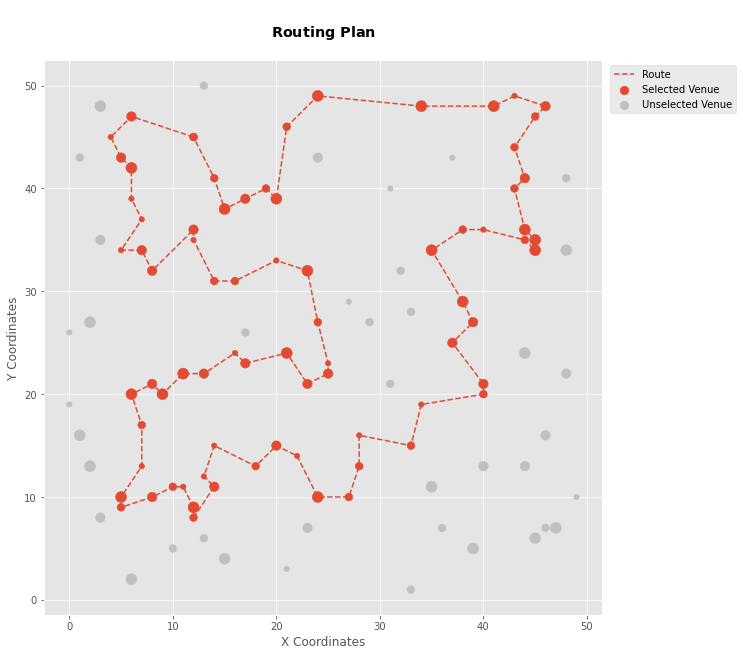

In [19]:
# Selected Venues
vx = pd.Series(tour).apply(lambda node: data.loc[node]["x"]).tolist()
vy = pd.Series(tour).apply(lambda node: data.loc[node]["y"]).tolist()
vscalar = pd.Series(tour).apply(lambda node: 30*data.loc[node]["demand"]).tolist() # scale the dot size by demand*25

# Unselected Venues
u_v = []
for v in data.index:
    if v not in tour:
        u_v.append(v)

u_vx = pd.Series(u_v).apply(lambda node: data.loc[node]["x"]).tolist()
u_vy = pd.Series(u_v).apply(lambda node: data.loc[node]["y"]).tolist()
u_vscalar = pd.Series(u_v).apply(lambda node: 30*data.loc[node]["demand"]).tolist() # scale the dot size by demand*25

assert len(vx) == len(vy) == len(vscalar)

# Round back to the first node
vx.append(vx[0])
vy.append(vy[0])
vscalar.append(vscalar[0])

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize = (10, 10), dpi = 72)

ax.scatter(vx, vy, s = vscalar)
ax.scatter(u_vx, u_vy, s = u_vscalar, color = "silver")
ax.plot(vx, vy, linestyle = "dashed")

ax.legend(["Route","Selected Venue","Unselected Venue"], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.title("\n"+r"$\bf{Routing\ Plan}$"+"\n")
plt.xlabel("X Coordinates")
plt.ylabel("Y Coordinates")

plt.show()